In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline

Create 20000 FGK dwarfs using the age distribution from Berger et al 2020a, with planets drawn from loguniform period distribution from 2 to 300 days, following the following cases:<br>

1) no difference between old and young stars, with 3 planets per star <br>
2) 10% of systems still intact (5 or 6 planets; < 2 Gyr old); 90% of systems disrupted (1 or 2 planets; > 2 Gyr) <br>

Why these two cases? Kepler data shows 7% (here we round to 10%) of systems are intact. We're using 2 Gyr instead of 1 Gyr like Berger et al in order to maintain the ~10%/90% proportion of sample sizes. ME FROM THE FUTURE: This is a wrong assumption. Skip to end of Case 2. <br>

#### The goal is to find out how many of these systems have transiting planets.

### Case 1

In [2]:
berger_kepler = pd.read_csv('berger_kepler_stellar17.csv')
print(len(berger_kepler))
print(berger_kepler.head())

19969
    kepid           tm_designation  teff  teff_err1  teff_err2   logg  \
0  757280  2MASS J19242289+3633538  6543      162.0     -194.0  4.082   
1  892667  2MASS J19243045+3637186  6609      159.0     -227.0  4.105   
2  892678  2MASS J19243108+3638316  6137      167.0     -186.0  3.936   
3  892713  2MASS J19243353+3637220  6106      186.0     -186.0  3.854   
4  892828  2MASS J19243904+3637166  6691      188.0     -235.0  4.134   

   logg_err1  logg_err2  feh_x  feh_err1  ...  parallax  parallax_err  feh_y  \
0      0.258     -0.172  -0.24      0.25  ...    1.2137        0.0220    NaN   
1      0.246     -0.164  -0.26      0.25  ...    0.8512        0.0154    NaN   
2      0.428     -0.143  -0.26      0.30  ...    1.0236        0.0259    NaN   
3      0.496     -0.124  -0.24      0.30  ...    0.9602        0.0231    NaN   
4      0.209     -0.171  -0.26      0.25  ...    0.9660        0.0143    NaN   

   feh_err    RUWE  num_gaia_companions  Kmag_final_prov  evstate      log

/Users/chris/anaconda2/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3072: DtypeWarning: Columns (138) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


[ 409 1918 2978 3679 3709 2930 1248  638  469  431  369  348  290  211
  153   85   53   38    9    4]
[0.14   0.5575 0.975  1.3925 1.81   2.2275 2.645  3.0625 3.48   3.8975
 4.315  4.7325 5.15   5.5675 5.985  6.4025 6.82   7.2375 7.655  8.0725
 8.49  ]


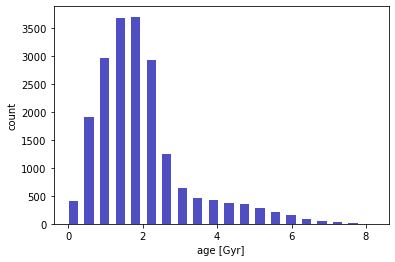

In [38]:
# age histogram for the 20000 FGK non-binary dwarfs from Berger et al 2020a with well-constrained ages
nbins = 20
age_hist, age_bin_edges = np.histogram(berger_kepler.iso_age, bins=nbins)
print(age_hist)
print(age_bin_edges)
plt.bar(age_bin_edges[:-1], age_hist, width = 0.25, color='#0504aa',alpha=0.7)
plt.ylabel("count")
plt.xlabel("age [Gyr]")
plt.show()

Time for kernel density estimator? https://jakevdp.github.io/PythonDataScienceHandbook/05.13-kernel-density-estimation.html

/Users/chris/anaconda2/lib/python3.6/site-packages/ipykernel_launcher.py:6: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  


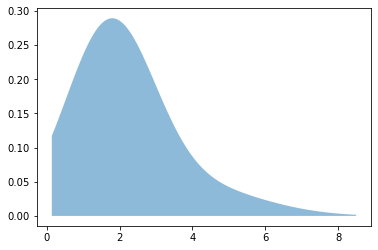

In [7]:
from sklearn.neighbors import KernelDensity

x = berger_kepler.iso_age
# instantiate and fit the KDE model
kde = KernelDensity(bandwidth=1.0, kernel='gaussian') # what else might be better?
kde.fit(x[:, None])

x_d = np.linspace(np.min(x),np.max(x),1000)
# score_samples returns the log of the probability density
logprob = kde.score_samples(x_d[:, None])

plt.fill_between(x_d, np.exp(logprob), alpha=0.5)
plt.show()

0.16134894568048957
0.13801577758850292
20000 [2.53884885 2.47198198 2.03734735 ... 2.45526527 1.81167167 2.27973974]


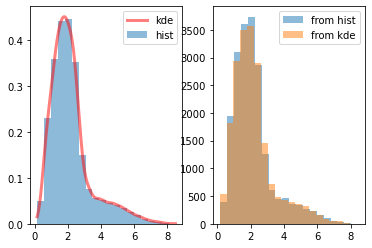

[1.36032032 1.57763764 3.15736737 ... 2.94005005 2.00391391 2.06242242]


In [165]:
# courtesy of https://stackoverflow.com/questions/17821458/random-number-from-histogram
from scipy.stats import gaussian_kde

def generate_rand_from_pdf(pdf, x_grid, n):
    cdf = np.cumsum(pdf) # create cdf
    cdf = cdf / cdf[-1] # normalize cdf
    values = np.random.rand(n) 
    value_bins = np.searchsorted(cdf, values) # return positions in cdf vector where random values should go
    random_from_cdf = x_grid[value_bins] # select x_d positions based on these random positions
    return random_from_cdf

def kde(x, x_grid, bandwidth):
    """Kernel Density Estimation with Scipy"""
    #kde = gaussian_kde(x, bw_method=bandwidth / x.std(ddof=0)) # ddof=1 means std divisor is N-1 instead of N
    #kde = gaussian_kde(x, bw_method=np.power(len(x), -0.2)) # ddof=1 means std divisor is N-1 instead of N
    kde = gaussian_kde(x, bw_method=0.15) # constant bandwidth so imbalance in sample size doesn't drive distribution
    print(bandwidth/x.std(ddof=1)) # this is bw used in S/O
    print(np.power(len(x), -0.2)) # the bw if I use Scott's factor as the bw to multiply with covariance matrix
    return kde.evaluate(x_grid)

#kdepdf = kde(x, x_d, bandwidth=0.1) # generate KDE model
#random_from_kde = generate_rand_from_pdf(kdepdf, x_d) # generate random data from KDE distribution

nbins = 20
def run_kde(data, draws):
    hist, bins = np.histogram(data, bins=100)

    x_grid = np.linspace(min(data), max(data), 1000)
    kdepdf = kde(data, x_grid, bandwidth=0.2) # generate KDE model
    random_from_kde = generate_rand_from_pdf(kdepdf, x_grid, draws) # generate random data from KDE distribution
    print(len(random_from_kde), random_from_kde) # these are my star ages
    bin_midpoints = bins[:-1] + np.diff(bins) / 2 # get positions of bin midpoints
    random_from_cdf = generate_rand_from_pdf(hist, bin_midpoints, draws) # generate random data from the histogram

    plt.subplot(121)
    plt.hist(data, nbins, density=True, alpha=0.5, label='hist') # plot histogram of normalized data
    plt.plot(x_grid, kdepdf, color='r', alpha=0.5, lw=3, label='kde') # plot KDE over normalized histogram
    plt.legend()
    plt.subplot(122)
    plt.hist(random_from_cdf, nbins, alpha=0.5, label='from hist') # plot histogram of data drawn from OG histogram
    plt.hist(random_from_kde, nbins, alpha=0.5, label='from kde') # plot histogram of data drawn from KDE
    plt.legend()
    plt.show()
    return random_from_kde, random_from_cdf
    
stars_age1_kde, stars_age1_cdf = run_kde(berger_kepler.iso_age, 20000)
print(stars_age1)

60000 [28.96290115 32.93510721  3.12943057 ... 23.72876427 59.52864176
 77.97835584]
[25595  7555  4610  3334  2634  2105  1812  1573  1406  1201  1090  1003
   963   885   801   741   684   672   643   693]
[  2.00018634  16.90010216  31.80001798  46.6999338   61.59984961
  76.49976543  91.39968125 106.29959707 121.19951289 136.0994287
 150.99934452 165.89926034 180.79917616 195.69909197 210.59900779
 225.49892361 240.39883943 255.29875525 270.19867106 285.09858688
 299.9985027 ]


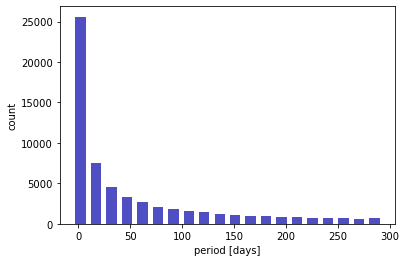

In [210]:
# host star follows age distribution of Berger et al 2020a
# 3 planets per star, with periods following loguniform distribution in [2, 300] days
from scipy.stats import loguniform

planets_per1 = loguniform.rvs(2, 300, size=60000)
print(len(planets_per1), planets_per1)

# histogram for 60000 planet periods
per_hist, per_bin_edges = np.histogram(planets_per1, bins=nbins)
print(per_hist)
print(per_bin_edges)
plt.bar(per_bin_edges[:-1], per_hist, width = 10, color='#0504aa',alpha=0.7)
plt.ylabel("count")
plt.xlabel("period [days]")
plt.show()

[3000 3099 2970 2918 2980 3085 2979 3005 2875 3051 3066 2938 2999 3030
 2931 2979 3063 3025 2993 3014]
[0.69314878 0.94367326 1.19419774 1.44472222 1.69524669 1.94577117
 2.19629565 2.44682013 2.69734461 2.94786909 3.19839357 3.44891805
 3.69944252 3.949967   4.20049148 4.45101596 4.70154044 4.95206492
 5.2025894  5.45311388 5.70363835]


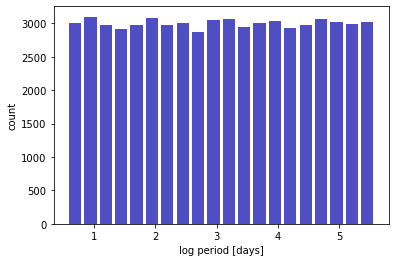

In [159]:
per_hist, per_bin_edges = np.histogram(np.log(planets_per1), bins=nbins)
print(per_hist)
print(per_bin_edges)
plt.bar(per_bin_edges[:-1], per_hist, width = 0.2, color='#0504aa',alpha=0.7)
plt.ylabel("count")
plt.xlabel("log period [days]")
plt.show()

### Case 2

1.1170311000339714
0.20889447103113198
2000 [0.89411411 0.63241241 0.62724725 ... 0.98278278 0.98708709 0.77961962]


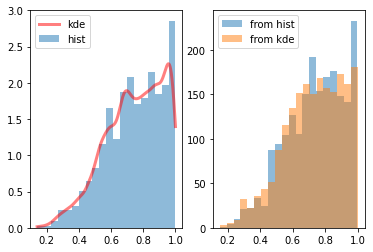

In [160]:
# 2000 systems with five or six planets and age <2 Gyr
# 18000 systems with one or two planets and age >2 Gyr
# should the age distribution be a truncated version of the KDE below and above 2 Gyr? yes
# going back and using a threshold of 1 Gyr like Berger et al 2020 b/c the proportion of young/old is more realistic
young = berger_kepler.loc[berger_kepler.iso_age <= 1.].iso_age
old = berger_kepler.loc[berger_kepler.iso_age > 1.].iso_age

stars_age2_young_kde, stars_age2_young_cdf = run_kde(young, 2000)

11000 [22.36437452  7.43012883  4.85382423 ... 45.45627429 26.03902747
 12.63501201]
[4604 1417  827  631  460  396  308  300  247  252  213  197  198  155
  156  138  137  131  122  111]
[  2.00047179  16.896278    31.79208421  46.68789042  61.58369663
  76.47950284  91.37530905 106.27111526 121.16692148 136.06272769
 150.9585339  165.85434011 180.75014632 195.64595253 210.54175874
 225.43756495 240.33337116 255.22917737 270.12498358 285.02078979
 299.916596  ]


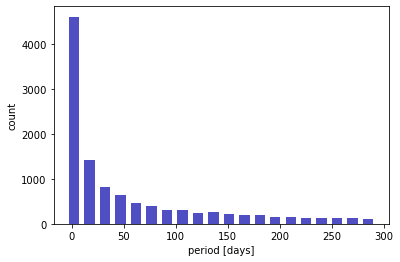

In [161]:
# generate five or six planets for each of the 2000 systems --> 11000 planets
planets_per2_young = loguniform.rvs(2, 300, size=11000)
print(len(planets_per2_young), planets_per2_young)

# histogram for 11000 planet periods
per_hist, per_bin_edges = np.histogram(planets_per2_young, bins=nbins)
print(per_hist)
print(per_bin_edges)
plt.bar(per_bin_edges[:-1], per_hist, width = 10, color='#0504aa',alpha=0.7)
plt.ylabel("count")
plt.xlabel("period [days]")
plt.show()

0.16776569556283707
0.14178034518473398
18000 [3.03910911 2.04327327 2.23794795 ... 2.00583584 2.41764765 2.39518519]


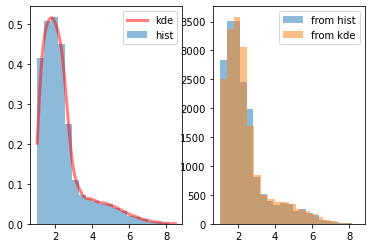

In [162]:
stars_age2_old_kde, stars_age2_old_cdf = run_kde(old, 18000)

27000 [30.82997069 62.13318692  3.13378299 ... 46.30925709  2.23659075
  6.82248821]
[11429  3426  2080  1512  1157   944   828   714   619   592   515   460
   395   405   366   339   338   293   307   281]
[  2.00031226  16.89920735  31.79810244  46.69699754  61.59589263
  76.49478772  91.39368282 106.29257791 121.191473   136.0903681
 150.98926319 165.88815828 180.78705338 195.68594847 210.58484356
 225.48373866 240.38263375 255.28152884 270.18042393 285.07931903
 299.97821412]


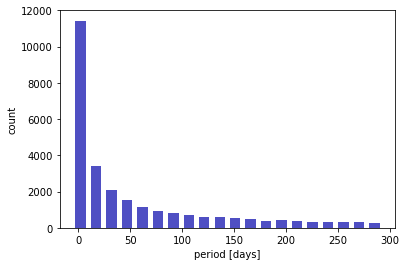

In [163]:
# generate one or two planets for each of the 18000 systems --> 27000 planets
planets_per2_young = loguniform.rvs(2, 300, size=27000)
print(len(planets_per2_young), planets_per2_young)

# histogram for 27000 planet periods
per_hist, per_bin_edges = np.histogram(planets_per2_young, bins=nbins)
print(per_hist)
print(per_bin_edges)
plt.bar(per_bin_edges[:-1], per_hist, width = 10, color='#0504aa',alpha=0.7)
plt.ylabel("count")
plt.xlabel("period [days]")
plt.show()

[ 109  371  575  731 3923 5709 2411 1273  844  869  762  711  556  414
  314  201  128   75   16    8]
[0.1790991  0.59464414 1.01018919 1.42573423 1.84127928 2.25682432
 2.67236937 3.08791441 3.50345946 3.9190045  4.33454955 4.75009459
 5.16563964 5.58118468 5.99672973 6.41227477 6.82781982 7.24336486
 7.65890991 8.07445495 8.49      ]


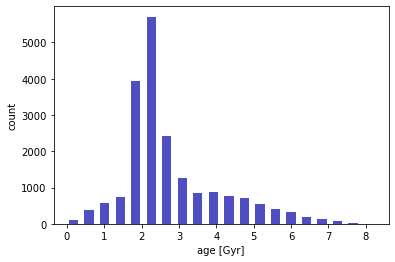

In [62]:
"""# age histogram for the Case 2 2000 synthetic young and 18000 synthetic old stars drawn from Berger age distribution, 2 Gyr threshold
nbins = 20
age_hist, age_bin_edges = np.histogram(list(stars_age2_young)+list(stars_age2_old), bins=nbins)
print(age_hist)
print(age_bin_edges)
plt.bar(age_bin_edges[:-1], age_hist, width = 0.25, color='#0504aa',alpha=0.7)
plt.ylabel("count")
plt.xlabel("age [Gyr]")
plt.show()
"""

Why da peak so high?? As we can see below, the 1 Gyr threshold is actually closer to the 10% split than the 2 Gyr threshold. So let's fall back to that.

In [79]:
# check percentage split of 1 Gyr age threshold vs 2 Gyr
print(len(berger_kepler.loc[berger_kepler.iso_age <= 1.]))
print(len(berger_kepler.loc[berger_kepler.iso_age > 1.]))
print(2514/len(berger_kepler))

print(len(berger_kepler.loc[berger_kepler.iso_age <= 2.]))
print(len(berger_kepler.loc[berger_kepler.iso_age > 2.]))
print(10814/len(berger_kepler))

# now check what threshold yields a 10%/90% young/old split
youngest_ten_percent = berger_kepler.iso_age.sort_values().head(int(len(berger_kepler)*(0.1))) # sort by ages and get first 10%
print(len(youngest_ten_percent))
print(youngest_ten_percent.tail())
print(len(stars_age1[:int(len(stars_age1) * 0.1)]))
print(stars_age1[:int(len(stars_age1) * 0.1)])


2514
17455
0.12589513746306777
10814
9155
0.5415393860483749
1996
11450    0.91
2020     0.92
11791    0.92
16754    0.92
919      0.92
Name: iso_age, dtype: float64
2000
[0.14       0.14835836 0.15671672 ... 0.90896897 0.90896897 0.90896897]


We'll go ahead and use 1 Gyr for now; we'll know from the transit simulation work whether a compact multi rate of 12.6% is consistent with the observed Kepler sample. Tuning this to get it to reproduce Kepler observations will be one of the next few steps anyway.

[ 380 1570 2735 3773 3950 2870 1421  689  499  436  412  383  264  237
  183   92   60   23   20    3]
[0.15205205 0.5682007  0.98434935 1.400498   1.81664665 2.2327953
 2.64894394 3.06509259 3.48124124 3.89738989 4.31353854 4.72968719
 5.14583584 5.56198448 5.97813313 6.39428178 6.81043043 7.22657908
 7.64272773 8.05887638 8.47502503]


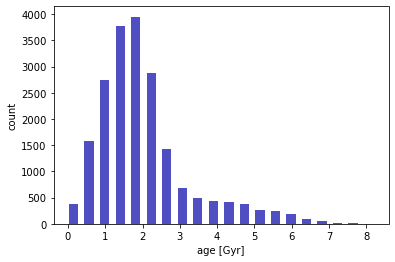

In [193]:
# age histogram for the Case 2 2000 synthetic young and 18000 synthetic old stars 
# drawn from two piecewise KDEs of the Berger age distribution
# 1 Gyr threshold
nbins = 20
age_hist, age_bin_edges = np.histogram(list(stars_age2_young_kde)+list(stars_age2_old_kde), bins=nbins)
print(age_hist)
print(age_bin_edges)
plt.bar(age_bin_edges[:-1], age_hist, width = 0.25, color='#0504aa',alpha=0.7)
plt.ylabel("count")
plt.xlabel("age [Gyr]")
plt.show()

0.1598387586494195
0.13797296614612148
5306
34694


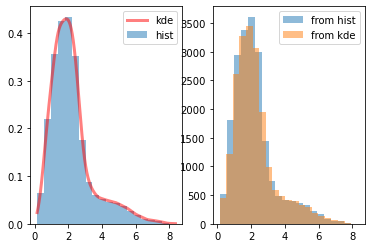

2000 18000


In [190]:
# maybe that was a bad idea to draw two separate piecewise KDEs
# instead, let's use the same KDE from Case 1 and just draw until we get 2000 young and 18000 old stars
def generate_rand_from_pdf_case2(pdf, x_grid, n_young, n_old):
    cdf = np.cumsum(pdf) # create cdf
    cdf = cdf / cdf[-1] # normalize cdf
    values = np.random.rand(2*(n_young+n_old))
    value_bins = np.searchsorted(cdf, values) # return positions in cdf vector where random values should go
    random_from_cdf = x_grid[value_bins] # select x_d positions based on these random positions
    # select 2000 young from Case 1 KDE draw
    case2_young = [i for i in random_from_cdf if i <= 1.]
    print(len(case2_young))
    case2_young = random.sample(case2_young, 2000)
    # else select old
    case2_old = [i for i in random_from_cdf if i > 1.]
    print(len(case2_old))
    case2_old = random.sample(case2_old, 18000)
    return case2_young, case2_old

def run_kde_case2(data, draws):
    hist, bins = np.histogram(data, bins=100)

    x_grid = np.linspace(min(data), max(data), 1000)
    kdepdf = kde(data, x_grid, bandwidth=0.2) # generate KDE model
    random_from_kde_young, random_from_kde_old = generate_rand_from_pdf_case2(kdepdf, x_grid, 2000, 18000) # generate random data from KDE distribution
    #print(len(random_from_kde), random_from_kde) # these are my star ages
    bin_midpoints = bins[:-1] + np.diff(bins) / 2 # get positions of bin midpoints
    random_from_cdf = generate_rand_from_pdf(hist, bin_midpoints, draws) # generate random data from the histogram

    plt.subplot(121)
    plt.hist(data, nbins, density=True, alpha=0.5, label='hist') # plot histogram of normalized data
    plt.plot(x_grid, kdepdf, color='r', alpha=0.5, lw=3, label='kde') # plot KDE over normalized histogram
    plt.legend()
    plt.subplot(122)
    plt.hist(random_from_cdf, nbins, alpha=0.5, label='from hist') # plot histogram of data drawn from OG histogram
    plt.hist(list(random_from_kde_young)+list(random_from_kde_old), nbins, alpha=0.5, label='from kde') # plot histogram of data drawn from KDE
    plt.legend()
    plt.show()
    return random_from_kde_young, random_from_kde_old

stars_age2_kde_young, stars_age2_kde_old = run_kde_case2(stars_age1_kde, 20000)
print(len(stars_age2_kde_young), len(stars_age2_kde_old))

[ 444 1363 2909 3533 3672 2903 1631  792  546  457  416  389  304  252
  143  112   58   40   30    6]
[0.14       0.54917678 0.95835356 1.36753035 1.77670713 2.18588391
 2.59506069 3.00423747 3.41341426 3.82259104 4.23176782 4.6409446
 5.05012138 5.45929816 5.86847495 6.27765173 6.68682851 7.09600529
 7.50518207 7.91435886 8.32353564]


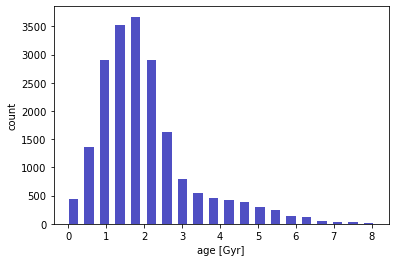

In [187]:
# age histogram for the Case 2 young and old stars, drawn from one continuous KDE fitted to Berger age distribution
# 1 Gyr threshold
nbins = 20
age_hist, age_bin_edges = np.histogram(list(stars_age2_kde_young)+list(stars_age2_kde_old), bins=nbins)
print(age_hist)
print(age_bin_edges)
plt.bar(age_bin_edges[:-1], age_hist, width = 0.25, color='#0504aa',alpha=0.7)
plt.ylabel("count")
plt.xlabel("age [Gyr]")
plt.show()

[ 531 1815 2934 3496 3576 2899 1452  720  489  435  385  359  315  224
  153   91   58   49   14    5]
[0.14       0.55164915 0.9632983  1.37494745 1.7865966  2.19824575
 2.60989489 3.02154404 3.43319319 3.84484234 4.25649149 4.66814064
 5.07978979 5.49143894 5.90308809 6.31473724 6.72638639 7.13803554
 7.54968468 7.96133383 8.37298298]


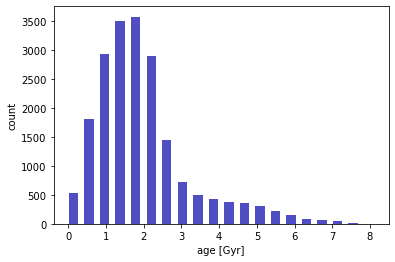

In [166]:
# age histogram for the Case 1 stars
# 1 Gyr threshold
nbins = 20
age_hist, age_bin_edges = np.histogram(list(stars_age1_kde), bins=nbins)
print(age_hist)
print(age_bin_edges)
plt.bar(age_bin_edges[:-1], age_hist, width = 0.25, color='#0504aa',alpha=0.7)
plt.ylabel("count")
plt.xlabel("age [Gyr]")
plt.show()

In [195]:
len([i for i in stars_age1_kde if i <= 1.])

2549

[ 409 1918 2978 3679 3709 2930 1248  638  469  431  369  348  290  211
  153   85   53   38    9    4]
[0.14   0.5575 0.975  1.3925 1.81   2.2275 2.645  3.0625 3.48   3.8975
 4.315  4.7325 5.15   5.5675 5.985  6.4025 6.82   7.2375 7.655  8.0725
 8.49  ]


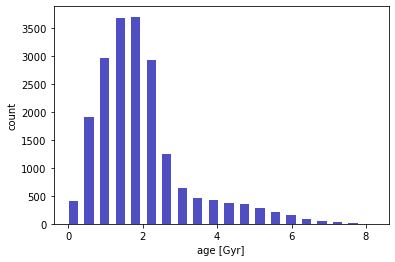

In [156]:
# age histogram for the 20000 FGK non-binary dwarfs from Berger et al 2020a with well-constrained ages
nbins = 20
age_hist, age_bin_edges = np.histogram(berger_kepler.iso_age, bins=nbins)
print(age_hist)
print(age_bin_edges)
plt.bar(age_bin_edges[:-1], age_hist, width = 0.25, color='#0504aa',alpha=0.7)
plt.ylabel("count")
plt.xlabel("age [Gyr]")
plt.show()

So there's three ways I can go about this. Do I 1) sample from 2 piecewise KDEs fit onto the <1 and >1 parts of the Berger age distribution; 2) sample generously from a single KDE on the Berger age distribution and draw however much I need from the <1 and >1 portions; or 3) just use the KDE from Case 1? Also, should I really be sampling 10%/90% if the true threshold is at 12.6%? If I do that, I'm undersampling for the already smaller young sample. And if I don't do that, then I might as well take option 3, right? <br> <br>

Let's just use the synthetic stars from Case 1 for now and fall back on different sampling proportions if the transit work doesn't look right, as Sarah said.

### Transits

In [218]:
# we use stars_age1_kde and planets_per1
# for each system, draw the midplane from uniform distribution, then draw planets' line of transit from Gaussian
# Case 1

midplanes = []
midplanes_degrees = []
impact_parameters = []
impact_parameters_degrees = []
#planets_per_case1 = [] # maybe better to recreate it here b/c I can then generalize it for Case 2?
sigma = 0.1 # THIS IS A BIG HYPERPARAM
sigma_degrees = 60
for star in stars_age1_kde:
    # star
    mu = np.random.uniform(-np.pi/2,np.pi/2,1) # create midplane for star
    mu_degrees = np.random.uniform(-90,90,1) # more interpretable
    midplanes.append(mu)
    midplanes_degrees.append(mu_degrees)
    
    # planet
    impact_parameters.append(np.random.normal(mu, sigma, 3)) # create impact params for planets
    impact_parameters_degrees.append(np.random.normal(mu_degrees, sigma_degrees, 3)) # create impact params for planets in degrees
    
midplanes = np.concatenate(midplanes, axis=0) # turn list of lists of one into regular list

planets_per_case1 = [planets_per1[p:p+3] for p in range(0, len(planets_per1), 3)] # reorganize list into list of lists of three

transits_dict = {'star_ages': stars_age1_kde, 'planet_periods': planets_per_case1,
                'midplane': midplanes, 'midplane_degrees': midplanes_degrees,
                 'b': impact_parameters, 'b_degrees': impact_parameters_degrees}
transits_case1 = pd.DataFrame(transits_dict)
print(transits_case1.head())

   star_ages                                     planet_periods  midplane  \
0   2.538849  [28.962901154389215, 32.935107208693005, 3.129...  1.346694   
1   2.471982  [4.2749942471965525, 54.29497921363007, 32.551... -0.058454   
2   2.037347  [2.7034630814412264, 2.808461136210068, 12.495... -1.379128   
3   1.677938  [66.12389653783926, 4.98321348358152, 2.669019...  0.021294   
4   0.683293  [56.671499868756264, 6.31065061421238, 2.75013...  0.292239   

       midplane_degrees                                                  b  \
0  [-68.70918473111877]  [1.431046541155278, 1.1248394768841938, 1.3629...   
1  [-50.19637696921149]  [0.06542672138447542, 0.060589785441788016, -0...   
2   [85.31837733652986]  [-1.4299151019068461, -1.3337671139151441, -1....   
3  [-4.355294509196568]  [0.18141409745786474, -0.11171531280385297, 0....   
4  [-64.22508368706465]  [0.44871524921530503, 0.2961184562806629, 0.20...   

                                           b_degrees  
0  [-154.1832

In [219]:
# we use stars_age1_kde and planets_per1
# for each system, draw the midplane from uniform distribution, then draw planets' line of transit from Gaussian
# Case 2

midplanes = []
midplanes_degrees = []
impact_parameters = []
impact_parameters_degrees = []
planets_per_case1 = [] # maybe better to recreate it here b/c I can then generalize it for Case 2?
sigma = 0.1 # THIS IS A BIG HYPERPARAM
sigma_degrees = 60
for star in stars_age1_kde:
    # star
    mu = np.random.uniform(-np.pi/2,np.pi/2,1) # create midplane for star
    mu_degrees = np.random.uniform(-90,90,1) # more interpretable
    midplanes.append(mu)
    midplanes_degrees.append(mu_degrees)
    
    # planet
    if star <= 1.:
        num_planets = random.choice([5, 6]) # young system has 5 or 6 planets
        planets_per_case1.append(loguniform.rvs(2, 300, size=num_planets)) # draw 5 or 6 planet periods from loguniform distribution
        impact_parameters.append(np.random.normal(mu, sigma, num_planets)) # create impact params for planets
        impact_parameters_degrees.append(np.random.normal(mu_degrees, sigma_degrees, num_planets)) # create impact params for planets in degrees
    elif star > 1.:
        num_planets = random.choice([1, 2]) # old system has 1 or 2 planets
        planets_per_case1.append(loguniform.rvs(2, 300, size=num_planets)) # draw 5 or 6 planet periods from loguniform distribution
        impact_parameters.append(np.random.normal(mu, sigma, num_planets)) # create impact params for planets
        impact_parameters_degrees.append(np.random.normal(mu_degrees, sigma_degrees, num_planets)) # create impact params for planets in degrees
        
midplanes = np.concatenate(midplanes, axis=0) # turn list of lists of one into regular list

#planets_per_case1 = [planets_per1[p:p+3] for p in range(0, len(planets_per1), 3)] # reorganize list into list of lists of three

transits_dict = {'star_ages': stars_age1_kde, 'planet_periods': planets_per_case1,
                'midplane': midplanes, 'midplane_degrees': midplanes_degrees,
                 'b': impact_parameters, 'b_degrees': impact_parameters_degrees}
transits_case2 = pd.DataFrame(transits_dict)
print(transits_case2.head())

   star_ages                                     planet_periods  midplane  \
0   2.538849                                [4.647721852165562]  0.242796   
1   2.471982            [17.96960975527876, 110.93162471450792] -0.332025   
2   2.037347              [18.68853745304684, 85.2942813760435] -0.824920   
3   1.677938            [20.942788852676383, 106.7968602949173] -0.267262   
4   0.683293  [51.203425179682384, 3.408338076728304, 44.922...  0.811543   

        midplane_degrees                                                  b  \
0  [-2.5145759598218547]                              [0.21772578348999963]   
1    [60.85756736656495]         [-0.2494556434332588, -0.4176353104188527]   
2    [71.75168112512029]         [-0.8818353137815661, -0.9007870105438541]   
3  [-58.998292370152704]        [-0.37608601452534873, -0.3449290617839561]   
4  [-30.354031756020788]  [0.7773117876038045, 0.8805658889287622, 0.932...   

                                           b_degrees  
0      